In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

S = np.load('data/S20_30.npy')
SS = np.array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, +1, -1, -1, -1, -1, -1, +1, -1, -1, -1, -1, -1, +1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, +1, +1, +1, -1, -1, -1, -1, -1, -1],
               [-1, +1, -1, -1, -1, -1, -1, +1, -1, +1, +1, +1, -1, +1, -1, -1, -1, -1]])

def pr(b, w, s1, s2, s3, s4):
    result = torch.cosh((b[0]+1j*b[1])+(w[0]+1j*w[4])*s1+(w[1]+1j*w[5])*s2+(w[2]+1j*w[6])*s3+(w[3]+1j*w[7])*s4)
    return result

def prr(br, bi, s1, s2, s3):
    result = torch.cosh((br + 1j * bi) + 1j * (np.pi/4) * (s1 + s2 + s3))
    return result

def prrr(br, bi, s1, s2, s3, s4, s5, s6):
    result = torch.cosh((br + 1j * bi) + 1j * (np.pi/4) * (s1 + s2 + s3 + s4 + s5 + s6))
    return result

def ph(nl, bv, wv, bf, wf, s):
    result = (np.exp(GL[0]+1j*GL[1])
              * prr(nl[0], nl[3], s[0], s[1], s[2]) * prr(nl[1], nl[4], s[3], s[9], s[15])
              * prrr(nl[2], nl[5], s[0], s[1], s[2], s[3], s[9], s[15])
              * pr(bv, wv, s[0], s[3], s[2], s[15]) * pr(bv, wv, s[1], s[4], s[0], s[16])
              * pr(bv, wv, s[2], s[5], s[1], s[17]) * pr(bv, wv, s[6], s[9], s[8], s[3])
              * pr(bv, wv, s[7], s[10], s[6], s[4]) * pr(bv, wv, s[8], s[11], s[7], s[5])
              * pr(bv, wv, s[12], s[15], s[14], s[9]) * pr(bv, wv, s[13], s[16], s[12], s[10])
              * pr(bv, wv, s[14], s[17], s[13], s[11]) * pr(bf, wf, s[4], s[6], s[3], s[0])
              * pr(bf, wf, s[5], s[7], s[4], s[1]) * pr(bf, wf, s[3], s[8], s[5], s[2])
              * pr(bf, wf, s[10], s[12], s[9], s[6]) * pr(bf, wf, s[11], s[13], s[10], s[7])
              * pr(bf, wf, s[9], s[14], s[11], s[8]) * pr(bf, wf, s[16], s[0], s[15], s[12])
              * pr(bf, wf, s[17], s[1], s[16], s[13]) * pr(bf, wf, s[15], s[2], s[17], s[14]))
    return result

# The 9 vertex operators flip qubits.
A1 = np.diag([-1, +1, -1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, +1])
A2 = np.diag([-1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1])
A3 = np.diag([+1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1])
A4 = np.diag([+1, +1, +1, -1, +1, +1, -1, +1, -1, -1, +1, +1, +1, +1, +1, +1, +1, +1])
A5 = np.diag([+1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1])
A6 = np.diag([+1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1])
A7 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, +1, -1, +1, -1, -1, +1, +1])
A8 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1])
A9 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1])
S1 = np.dot(S, A1)
S2 = np.dot(S, A2)
S3 = np.dot(S, A3)
S4 = np.dot(S, A4)
S5 = np.dot(S, A5)
S6 = np.dot(S, A6)
S7 = np.dot(S, A7)
S8 = np.dot(S, A8)
S9 = np.dot(S, A9)

# lam is the multiplier to amplify the choice of ground state
def criterion(nl, bv, wv, bf, wf):
    V = torch.empty((18*N+3,), dtype=torch.complex64)
    nor = torch.empty((N,), dtype=torch.complex64)
    for k in range(N):
        one = ph(nl, bv, wv, bf, wf, SS[0])
        sub = ph(nl, bv, wv, bf, wf, S[k])
        nor[k] = sub
        V[k] = ph(nl, bv, wv, bf, wf, S1[k]) - sub
        V[1*N+k] = ph(nl, bv, wv, bf, wf, S2[k]) - sub
        V[2*N+k] = ph(nl, bv, wv, bf, wf, S3[k]) - sub
        V[3*N+k] = ph(nl, bv, wv, bf, wf, S4[k]) - sub
        V[4*N+k] = ph(nl, bv, wv, bf, wf, S5[k]) - sub
        V[5*N+k] = ph(nl, bv, wv, bf, wf, S6[k]) - sub
        V[6*N+k] = ph(nl, bv, wv, bf, wf, S7[k]) - sub
        V[7*N+k] = ph(nl, bv, wv, bf, wf, S8[k]) - sub
        V[8*N+k] = ph(nl, bv, wv, bf, wf, S9[k]) - sub
        V[9*N+k] = (S[k][4]*S[k][6]*S[k][3]*S[k][0]-1) * sub
        V[10*N+k] = (S[k][5]*S[k][7]*S[k][4]*S[k][1]-1) * sub
        V[11*N+k] = (S[k][3]*S[k][8]*S[k][5]*S[k][2]-1) * sub
        V[12*N+k] = (S[k][10]*S[k][12]*S[k][9]*S[k][6]-1) * sub
        V[13*N+k] = (S[k][11]*S[k][13]*S[k][10]*S[k][7]-1) * sub
        V[14*N+k] = (S[k][9]*S[k][14]*S[k][11]*S[k][8]-1) * sub
        V[15*N+k] = (S[k][16]*S[k][0]*S[k][15]*S[k][12]-1) * sub
        V[16*N+k] = (S[k][17]*S[k][1]*S[k][16]*S[k][13]-1) * sub
        V[17*N+k] = (S[k][15]*S[k][2]*S[k][17]*S[k][14]-1) * sub
        V[18*N+0] = lam * (ph(nl, bv, wv, bf, wf, SS[1])-(bb/aa)*one)
        V[18*N+1] = lam * (ph(nl, bv, wv, bf, wf, SS[2])-(cc/aa)*one)
        V[18*N+2] = lam * (ph(nl, bv, wv, bf, wf, SS[3])-(dd/aa)*one)
    v = torch.norm(V,p=2)/torch.norm(nor,p=1)
    return v

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# initial setting with the basis ratio (aa, bb, cc, dd)
# This ratio represents the ratio of coefficients of four ground state basis for a unique ground state of toric code 
(aa, bb, cc, dd, lam) = (1, 2, 3, 4, 1.0)
(ss, tt, N) = (0.0001, 10000, len(S))
BF = torch.tensor([0.0, 0.0])
WF = torch.tensor([0.0, 0.0, 0.0, 0.0, np.pi/4, np.pi/4, np.pi/4, np.pi/4])
BV = torch.tensor([0.0, 0.0])
WV = torch.tensor([0.0, 0.0, 0.0, 0.0, np.pi/2, np.pi/2, np.pi/2, np.pi/2])
# global constant GL change the overall phase to modify aa, bb, cc, dd
GL = torch.tensor([0.0, 0.0])
# NL stores all nonlocal weights bx, by, bz in C, wx=wy=wz=pi/4 i
# NL = [Re(bx),Re(by),Re(bz),Im(bx),Im(by),Im(bz)]
NL = torch.tensor([1.0, 0.1, 1.0, 1.1, 0.5, 0.3], requires_grad=True)
optimizer = torch.optim.Adam([NL], lr=ss)

# Adam gradient descent
start_time = time.time()
COST = []
ANL = [[], [], [], [], [], []]
for h in range(tt):
    cost = criterion(NL, BV, WV, BF, WF)
    COST.append(cost.tolist())
    for p in range(6):
        ANL[p].append(NL[p].tolist())
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
end_time = time.time()
execution_time = end_time - start_time

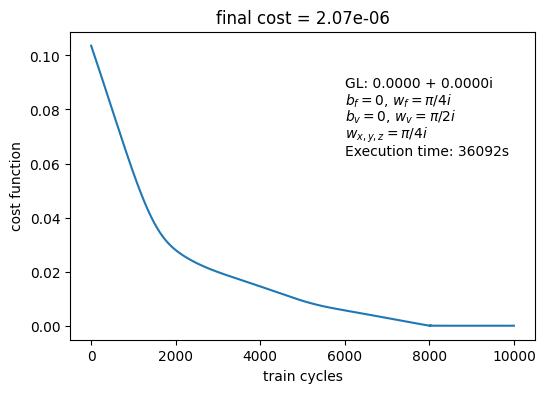

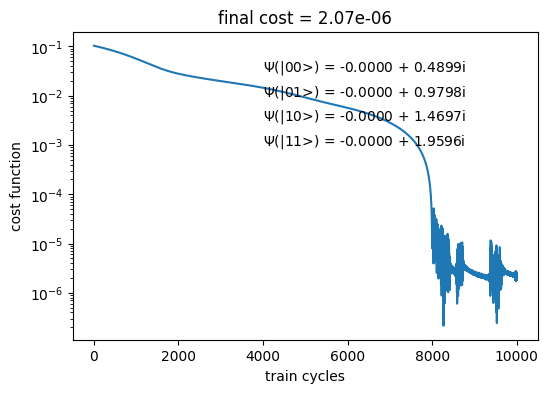

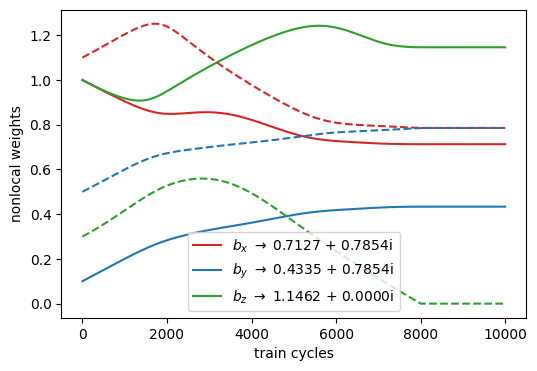

In [ ]:
# Visualize training cycles up to t
t = (tt - 1)
Final = COST[t]
NLt = torch.tensor([ANL[0][t], ANL[1][t], ANL[2][t], ANL[3][t], ANL[4][t], ANL[5][t]])

fig0 = plt.figure(figsize=(6, 4))
plt.plot(COST[0:t])
plt.title("final cost = %.2e" % Final)
plt.text(0.6 * t, 0.85 * COST[0], "GL: %.4f + %.4fi" %(GL[0],GL[1]))
plt.text(0.6 * t, 0.79 * COST[0], "$b_{f} = 0$, $w_{f} = \pi/4 i$")
plt.text(0.6 * t, 0.73 * COST[0], "$b_{v} = 0$, $w_{v} = \pi/2 i$")
plt.text(0.6 * t, 0.67 * COST[0], "$w_{x,y,z} = \pi/4 i$")
plt.text(0.6 * t, 0.61 * COST[0], "Execution time: %is" % execution_time)
plt.xlabel("train cycles")
plt.ylabel("cost function")
plt.show()

fig1 = plt.figure(figsize=(6, 4))
plt.plot(COST[0:t])
plt.title("final cost = %.2e" % Final)
plt.text(0.4 * t, 10 ** (-1.5), "$\Psi$(|00>) = %.4f + %.4fi" % (
    ph(NLt, BV, WV, BF, WF, SS[0]).data.item().real, ph(NLt, BV, WV, BF, WF, SS[0]).data.item().imag))
plt.text(0.4 * t, 10 ** (-2.0), "$\Psi$(|01>) = %.4f + %.4fi" % (
    ph(NLt, BV, WV, BF, WF, SS[1]).data.item().real, ph(NLt, BV, WV, BF, WF, SS[1]).data.item().imag))
plt.text(0.4 * t, 10 ** (-2.5), "$\Psi$(|10>) = %.4f + %.4fi" % (
    ph(NLt, BV, WV, BF, WF, SS[2]).data.item().real, ph(NLt, BV, WV, BF, WF, SS[2]).data.item().imag))
plt.text(0.4 * t, 10 ** (-3.0), "$\Psi$(|11>) = %.4f + %.4fi" % (
    ph(NLt, BV, WV, BF, WF, SS[3]).data.item().real, ph(NLt, BV, WV, BF, WF, SS[3]).data.item().imag))
plt.xlabel("train cycles")
plt.ylabel("cost function")
plt.yscale('log')
plt.show()

fig2 = plt.figure(figsize=(6, 4))
plt.plot(ANL[0][0:t], color='tab:red', label=r"$b_x$ $\rightarrow$ %.4f + %.4fi" % (ANL[0][t],ANL[3][t]))
plt.plot(ANL[1][0:t], color='tab:blue', label=r"$b_y$ $\rightarrow$ %.4f + %.4fi" % (ANL[1][t],ANL[4][t]))
plt.plot(ANL[2][0:t], color='tab:green', label=r"$b_z$ $\rightarrow$ %.4f + %.4fi" % (ANL[2][t],ANL[5][t]))
plt.plot(ANL[3][0:t], '--', color='tab:red')
plt.plot(ANL[4][0:t], '--', color='tab:blue')
plt.plot(ANL[5][0:t], '--', color='tab:green')
plt.xlabel("train cycles")
plt.ylabel("nonlocal weights")
plt.legend()
plt.show()

# **Above, we use GL=0 to learn and change GL to replot**
# **Below, we change to alterable GL and make the variables closer**

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from google.colab import drive
drive.mount('/content/drive')
S = np.load('/content/drive/My Drive/Toric Code 2D/3: FRRBM on 3x3/Data/S20_30.npy')
SS = np.array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, +1, -1, -1, -1, -1, -1, +1, -1, -1, -1, -1, -1, +1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, +1, +1, +1, -1, -1, -1, -1, -1, -1],
               [-1, +1, -1, -1, -1, -1, -1, +1, -1, +1, +1, +1, -1, +1, -1, -1, -1, -1]])

def pr(b, w, s1, s2, s3, s4):
    result = torch.cosh((b[0]+1j*b[1])+(w[0]+1j*w[4])*s1+(w[1]+1j*w[5])*s2+(w[2]+1j*w[6])*s3+(w[3]+1j*w[7])*s4)
    return result

def prr(br, bi, s1, s2, s3):
    result = torch.cosh((br + 1j * bi) + 1j * (np.pi/4) * (s1 + s2 + s3))
    return result

def prrr(br, bi, s1, s2, s3, s4, s5, s6):
    result = torch.cosh((br + 1j * bi) + 1j * (np.pi/4) * (s1 + s2 + s3 + s4 + s5 + s6))
    return result

def ph(gl, nl, bv, wv, bf, wf, s):
    result = (torch.exp(gl[0]+1j*gl[1])
              * prr(nl[0], nl[3], s[0], s[1], s[2]) * prr(nl[1], nl[4], s[3], s[9], s[15])
              * prrr(nl[2], nl[5], s[0], s[1], s[2], s[3], s[9], s[15])
              * pr(bv, wv, s[0], s[3], s[2], s[15]) * pr(bv, wv, s[1], s[4], s[0], s[16])
              * pr(bv, wv, s[2], s[5], s[1], s[17]) * pr(bv, wv, s[6], s[9], s[8], s[3])
              * pr(bv, wv, s[7], s[10], s[6], s[4]) * pr(bv, wv, s[8], s[11], s[7], s[5])
              * pr(bv, wv, s[12], s[15], s[14], s[9]) * pr(bv, wv, s[13], s[16], s[12], s[10])
              * pr(bv, wv, s[14], s[17], s[13], s[11]) * pr(bf, wf, s[4], s[6], s[3], s[0])
              * pr(bf, wf, s[5], s[7], s[4], s[1]) * pr(bf, wf, s[3], s[8], s[5], s[2])
              * pr(bf, wf, s[10], s[12], s[9], s[6]) * pr(bf, wf, s[11], s[13], s[10], s[7])
              * pr(bf, wf, s[9], s[14], s[11], s[8]) * pr(bf, wf, s[16], s[0], s[15], s[12])
              * pr(bf, wf, s[17], s[1], s[16], s[13]) * pr(bf, wf, s[15], s[2], s[17], s[14]))
    return result

# The 9 vertex operators flip qubits.
A1 = np.diag([-1, +1, -1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, +1])
A2 = np.diag([-1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1])
A3 = np.diag([+1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1])
A4 = np.diag([+1, +1, +1, -1, +1, +1, -1, +1, -1, -1, +1, +1, +1, +1, +1, +1, +1, +1])
A5 = np.diag([+1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1, +1])
A6 = np.diag([+1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1, +1, +1, +1, +1, +1])
A7 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, +1, -1, +1, -1, -1, +1, +1])
A8 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1, +1])
A9 = np.diag([+1, +1, +1, +1, +1, +1, +1, +1, +1, +1, +1, -1, +1, -1, -1, +1, +1, -1])
S1 = np.dot(S, A1)
S2 = np.dot(S, A2)
S3 = np.dot(S, A3)
S4 = np.dot(S, A4)
S5 = np.dot(S, A5)
S6 = np.dot(S, A6)
S7 = np.dot(S, A7)
S8 = np.dot(S, A8)
S9 = np.dot(S, A9)

# lam is the multiplier to amplify the choice of ground state
def criterion(gl, nl, bv, wv, bf, wf):
    V = torch.empty((18*N+4,), dtype=torch.complex64)
    nor = torch.empty((N,), dtype=torch.complex64)
    for k in range(N):
        sub = ph(gl, nl, bv, wv, bf, wf, S[k])
        nor[k] = sub
        V[k] = ph(gl, nl, bv, wv, bf, wf, S1[k]) - sub
        V[1*N+k] = ph(gl, nl, bv, wv, bf, wf, S2[k]) - sub
        V[2*N+k] = ph(gl, nl, bv, wv, bf, wf, S3[k]) - sub
        V[3*N+k] = ph(gl, nl, bv, wv, bf, wf, S4[k]) - sub
        V[4*N+k] = ph(gl, nl, bv, wv, bf, wf, S5[k]) - sub
        V[5*N+k] = ph(gl, nl, bv, wv, bf, wf, S6[k]) - sub
        V[6*N+k] = ph(gl, nl, bv, wv, bf, wf, S7[k]) - sub
        V[7*N+k] = ph(gl, nl, bv, wv, bf, wf, S8[k]) - sub
        V[8*N+k] = ph(gl, nl, bv, wv, bf, wf, S9[k]) - sub
        V[9*N+k] = (S[k][4]*S[k][6]*S[k][3]*S[k][0]-1) * sub
        V[10*N+k] = (S[k][5]*S[k][7]*S[k][4]*S[k][1]-1) * sub
        V[11*N+k] = (S[k][3]*S[k][8]*S[k][5]*S[k][2]-1) * sub
        V[12*N+k] = (S[k][10]*S[k][12]*S[k][9]*S[k][6]-1) * sub
        V[13*N+k] = (S[k][11]*S[k][13]*S[k][10]*S[k][7]-1) * sub
        V[14*N+k] = (S[k][9]*S[k][14]*S[k][11]*S[k][8]-1) * sub
        V[15*N+k] = (S[k][16]*S[k][0]*S[k][15]*S[k][12]-1) * sub
        V[16*N+k] = (S[k][17]*S[k][1]*S[k][16]*S[k][13]-1) * sub
        V[17*N+k] = (S[k][15]*S[k][2]*S[k][17]*S[k][14]-1) * sub
        V[18*N+0] = lam * (ph(gl, nl, bv, wv, bf, wf, SS[0])-aa)
        V[18*N+1] = lam * (ph(gl, nl, bv, wv, bf, wf, SS[1])-bb)
        V[18*N+2] = lam * (ph(gl, nl, bv, wv, bf, wf, SS[2])-cc)
        V[18*N+3] = lam * (ph(gl, nl, bv, wv, bf, wf, SS[3])-dd)
    v = torch.norm(V,p=2)/torch.norm(nor,p=1)
    return v

In [ ]:
# initial setting with the basis ratio (aa, bb, cc, dd)
(aa, bb, cc, dd, lam) = (1, 2, 3, 4, 1.0)
(ss, tt, N) = (0.0001, 10000, len(S))
BF = torch.tensor([0.0, 0.0])
WF = torch.tensor([0.0, 0.0, 0.0, 0.0, np.pi/4, np.pi/4, np.pi/4, np.pi/4])
BV = torch.tensor([0.0, 0.0])
WV = torch.tensor([0.0, 0.0, 0.0, 0.0, np.pi/2, np.pi/2, np.pi/2, np.pi/2])
# global constant GL change the overall phase to modify aa, bb, cc, dd
GL = torch.tensor([0.75, -1.5], requires_grad=True)
# NL stores all nonlocal weights bx, by, bz in C, wx=wy=wz=pi/4 i
# NL = [Re(bx),Re(by),Re(bz),Im(bx),Im(by),Im(bz)]
NL = torch.tensor([0.7, 0.4, 1.1, 0.9, 0.8, 0.1], requires_grad=True)
optimizer = torch.optim.Adam([GL, NL], lr=ss)

# Stochastic gradient descent
start_time = time.time()
COST = []
ANL = [[], [], [], [], [], []]
AGL = [[], []]
for h in range(tt):
    cost = criterion(GL, NL, BV, WV, BF, WF)
    COST.append(cost.tolist())
    for q in range(2):
        AGL[q].append(GL[q].tolist())
    for p in range(6):
        ANL[p].append(NL[p].tolist())
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
end_time = time.time()
execution_time = end_time - start_time

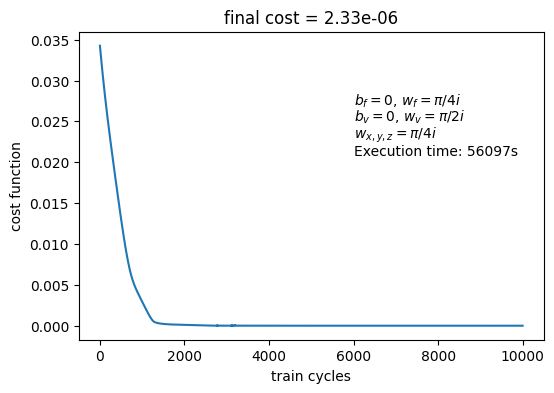

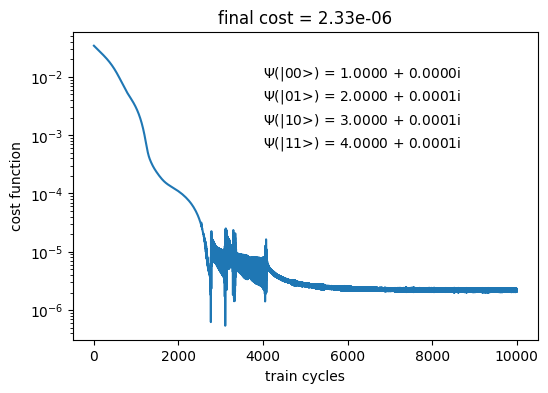

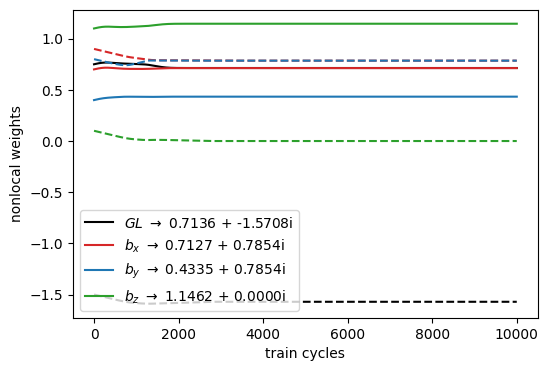

In [ ]:
# Visualize training cycles up to t
t = (10000 - 1)
Final = COST[t]
GLt = torch.tensor([AGL[0][t], AGL[1][t]])
NLt = torch.tensor([ANL[0][t], ANL[1][t], ANL[2][t], ANL[3][t], ANL[4][t], ANL[5][t]])

fig0 = plt.figure(figsize=(6, 4))
plt.plot(COST[0:t])
plt.title("final cost = %.2e" % Final)
plt.text(0.6 * t, 0.79 * COST[0], "$b_{f} = 0$, $w_{f} = \pi/4 i$")
plt.text(0.6 * t, 0.73 * COST[0], "$b_{v} = 0$, $w_{v} = \pi/2 i$")
plt.text(0.6 * t, 0.67 * COST[0], "$w_{x,y,z} = \pi/4 i$")
plt.text(0.6 * t, 0.61 * COST[0], "Execution time: %is" % execution_time)
plt.xlabel("train cycles")
plt.ylabel("cost function")
plt.show()

fig1 = plt.figure(figsize=(6, 4))
plt.plot(COST[0:t])
plt.title("final cost = %.2e" % Final)
plt.text(0.4 * t, 10 ** (-2.0), "$\Psi$(|00>) = %.4f + %.4fi" % (
    ph(GLt, NLt, BV, WV, BF, WF, SS[0]).data.item().real, ph(GLt, NLt, BV, WV, BF, WF, SS[0]).data.item().imag))
plt.text(0.4 * t, 10 ** (-2.4), "$\Psi$(|01>) = %.4f + %.4fi" % (
    ph(GLt, NLt, BV, WV, BF, WF, SS[1]).data.item().real, ph(GLt, NLt, BV, WV, BF, WF, SS[1]).data.item().imag))
plt.text(0.4 * t, 10 ** (-2.8), "$\Psi$(|10>) = %.4f + %.4fi" % (
    ph(GLt, NLt, BV, WV, BF, WF, SS[2]).data.item().real, ph(GLt, NLt, BV, WV, BF, WF, SS[2]).data.item().imag))
plt.text(0.4 * t, 10 ** (-3.2), "$\Psi$(|11>) = %.4f + %.4fi" % (
    ph(GLt, NLt, BV, WV, BF, WF, SS[3]).data.item().real, ph(GLt, NLt, BV, WV, BF, WF, SS[3]).data.item().imag))
plt.xlabel("train cycles")
plt.ylabel("cost function")
plt.yscale('log')
plt.show()

fig2 = plt.figure(figsize=(6, 4))
plt.plot(AGL[0][0:t], color='black', label=r"$GL$ $\rightarrow$ %.4f + %.4fi" % (AGL[0][t],AGL[1][t]))
plt.plot(ANL[0][0:t], color='tab:red', label=r"$b_x$ $\rightarrow$ %.4f + %.4fi" % (ANL[0][t],ANL[3][t]))
plt.plot(ANL[1][0:t], color='tab:blue', label=r"$b_y$ $\rightarrow$ %.4f + %.4fi" % (ANL[1][t],ANL[4][t]))
plt.plot(ANL[2][0:t], color='tab:green', label=r"$b_z$ $\rightarrow$ %.4f + %.4fi" % (ANL[2][t],ANL[5][t]))
plt.plot(AGL[1][0:t], '--', color='black')
plt.plot(ANL[3][0:t], '--', color='tab:red')
plt.plot(ANL[4][0:t], '--', color='tab:blue')
plt.plot(ANL[5][0:t], '--', color='tab:green')
plt.xlabel("train cycles")
plt.ylabel("nonlocal weights")
plt.legend()
plt.show()